<a href="https://colab.research.google.com/github/Sowmya721/Hybrid-Mushroom-Classification-System/blob/main/mushroom_classification_and_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#Installing dependencies
print(" Installing dependencies...")
!pip install -q gradio

from google.colab import files
import os, zipfile

 Installing dependencies...


In [2]:
print("Please upload your Mushrooms.zip file")
uploaded = files.upload()

for fname in uploaded.keys():
    zip_path = f"/content/{fname}"
    extract_path = "/content/Mushrooms"
    print(f"Extracting {fname}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

if os.path.exists("/content/Mushrooms/Mushrooms"):
    print("Fixing nested folder structure")
    !mv /content/Mushrooms/Mushrooms/* /content/Mushrooms/
    !rmdir /content/Mushrooms/Mushrooms

print("Dataset folders:")
for root, dirs, files in os.walk("/content/Mushrooms"):
    if len(files) > 0:
        print(root, "->", len(files), "files")

Please upload your Mushrooms.zip file


Saving Mushrooms.zip to Mushrooms.zip
Extracting Mushrooms.zip
Fixing nested folder structure
Dataset folders:
/content/Mushrooms/amanita fulva -> 51 files
/content/Mushrooms/podostroma cornu damae -> 36 files
/content/Mushrooms/amanita muscaria -> 48 files
/content/Mushrooms/agaricus arvensis -> 40 files


In [3]:
# Imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import itertools, random, warnings
warnings.filterwarnings('ignore')

In [4]:
# Preprocessing & Augmentation
def remove_background(img):
    """HSV-based background removal."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 30])
    upper = np.array([179, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    return result

def preprocess_image(img, augment=True):
    """Crop, normalize brightness, augment."""
    if img is None:
        return None
    img = remove_background(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    x, y, w, h = cv2.boundingRect(mask)
    if w == 0 or h == 0:
        cropped = img
    else:
        cropped = img[y:y+h, x:x+w]
    cropped = cv2.resize(cropped, (128, 128))
    if augment:
        cropped = cv2.convertScaleAbs(cropped, alpha=random.uniform(0.9,1.1), beta=random.randint(-10,10))
        if random.random() < 0.3:
            cropped = cv2.flip(cropped, 1)
        if random.random() < 0.3:
            M = cv2.getRotationMatrix2D((64,64), random.randint(-20,20), 1)
            cropped = cv2.warpAffine(cropped, M, (128,128))
    return cropped


In [5]:
# Feature Extraction Functions
def extract_order1_features(gray):
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
    hist_prob = hist / np.sum(hist)
    gray_levels = np.arange(256)
    mean = np.sum(gray_levels * hist_prob)
    variance = np.sum(((gray_levels - mean) ** 2) * hist_prob)
    skewness = skew(gray.flatten())
    kurt_val = kurtosis(gray.flatten())
    entropy = -np.sum(hist_prob * np.log2(hist_prob + 1e-7))
    return [mean, variance, skewness, kurt_val, entropy]

def extract_color_features(img):
    features = []
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    for space in [hsv, lab]:
        chans = cv2.split(space)
        for c in chans:
            features += [np.mean(c), np.std(c), skew(c.flatten()), kurtosis(c.flatten())]
    return features

def extract_glcm_features(gray):
    gray = cv2.resize(gray, (128, 128))
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    return [graycoprops(glcm, p).mean() for p in ['contrast', 'homogeneity', 'energy', 'correlation']]

def extract_hog_features(gray):
    gray = cv2.resize(gray, (128, 128))
    features, _ = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                      cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    return features[:50]

def extract_lbp_features(gray):
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist / np.sum(hist)
    return hist.tolist()

In [6]:
# Deep Features (ResNet50)
print("Loading ResNet50")
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_resnet_features(img):
    img = cv2.resize(img, (224, 224))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    features = resnet_model.predict(x, verbose=0)
    return features.flatten()

Loading ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Combined Feature Extraction
def extract_all_features(image_path, augment=True):
    img = cv2.imread(image_path)
    img = preprocess_image(img, augment=augment)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    f1 = extract_order1_features(gray)
    f2 = extract_glcm_features(gray)
    f3 = extract_hog_features(gray)
    f4 = extract_color_features(img)
    f5 = extract_lbp_features(gray)
    f6 = extract_resnet_features(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    return np.concatenate([f1, f2, f3, f4, f5, f6])

def extract_all_features_from_array(img_array, augment=False):
    """Extract features from numpy array (for web app)"""
    img = preprocess_image(img_array, augment=augment)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    f1 = extract_order1_features(gray)
    f2 = extract_glcm_features(gray)
    f3 = extract_hog_features(gray)
    f4 = extract_color_features(img)
    f5 = extract_lbp_features(gray)
    f6 = extract_resnet_features(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    return np.concatenate([f1, f2, f3, f4, f5, f6])

In [8]:
# Build Dataset
base_dir = '/content/Mushrooms'
classes = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
print("\n Detected classes:", classes)

data, labels = [], []
print("\n Extracting features from images")
for label in classes:
    folder = os.path.join(base_dir, label)
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif', '.webp')):
            path = os.path.join(folder, file)
            features = extract_all_features(path)
            if features is not None:
                data.append(features)
                labels.append(label)

df = pd.DataFrame(data)
df['Label'] = labels
print(f"\n Dataset built: {len(df)} samples, {df.shape[1]-1} features\n")


 Detected classes: ['agaricus arvensis', 'amanita fulva', 'amanita muscaria', 'podostroma cornu damae']

 Extracting features from images

 Dataset built: 175 samples, 2141 features



In [9]:
# Split + Scale + Balance + PCA + Poly + Feature Selection
print(" Preprocessing data")
X = df.drop(columns=['Label'])
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_s, y_train)

pca = PCA(n_components=100)
X_train_p = pca.fit_transform(X_train_bal)
X_test_p = pca.transform(X_test_s)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_p)
X_test_poly = poly.transform(X_test_p)

selector = SelectKBest(mutual_info_classif, k=120)
X_train_sel = selector.fit_transform(X_train_poly, y_train_bal)
X_test_sel = selector.transform(X_test_poly)

 Preprocessing data


In [10]:
#Models + Ensemble
print("\n Training models")
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

results, best_models = {}, {}

for name, model in models.items():
    print(f"  Training {name}...")
    model.fit(X_train_sel, y_train_bal)
    preds = model.predict(X_test_sel)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    best_models[name] = model
    print(f"  ✓ {name} Accuracy: {acc:.4f}")

# Ensemble
print("\n  Training Ensemble...")
ensemble = VotingClassifier(estimators=[
    ('rf', best_models['Random Forest']),
    ('svm', best_models['SVM']),
    ('lr', best_models['Logistic Regression'])
], voting='soft')
ensemble.fit(X_train_sel, y_train_bal)
ens_acc = accuracy_score(y_test, ensemble.predict(X_test_sel))
results["Ensemble"] = ens_acc
print(f"  ✓ Ensemble Model Accuracy: {ens_acc:.4f}")


 Training models
  Training Decision Tree...
  ✓ Decision Tree Accuracy: 0.6792
  Training Random Forest...
  ✓ Random Forest Accuracy: 0.8491
  Training Logistic Regression...
  ✓ Logistic Regression Accuracy: 0.7547
  Training SVM...
  ✓ SVM Accuracy: 0.8113
  Training KNN...
  ✓ KNN Accuracy: 0.5283
  Training Naive Bayes...
  ✓ Naive Bayes Accuracy: 0.7925

  Training Ensemble...
  ✓ Ensemble Model Accuracy: 0.8113



 Model Comparison:
                  Model  Accuracy
1        Random Forest  0.849057
6             Ensemble  0.811321
3                  SVM  0.811321
5          Naive Bayes  0.792453
2  Logistic Regression  0.754717
0        Decision Tree  0.679245
4                  KNN  0.528302


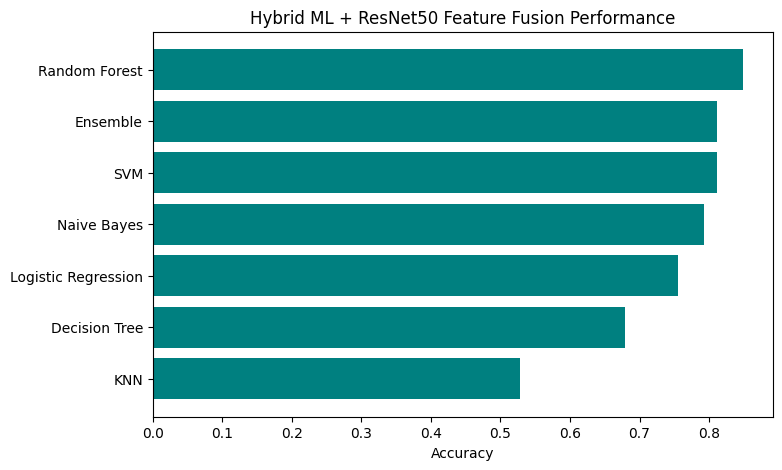

In [11]:
#Results Visualization
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\n Model Comparison:\n", results_df)

plt.figure(figsize=(8,5))
plt.barh(results_df['Model'], results_df['Accuracy'], color='teal')
plt.xlabel('Accuracy')
plt.title('Hybrid ML + ResNet50 Feature Fusion Performance')
plt.gca().invert_yaxis()
plt.show()

In [12]:
# CREATE GRADIO WEB APP
print("\n" + "="*50)
print(" CREATING WEB APPLICATION WITH GRADIO")
print("="*50)

import gradio as gr
from PIL import Image

def predict_mushroom(image):
    """Prediction function for Gradio"""
    try:
        # Convert PIL Image to numpy array
        img_array = np.array(image)

        # Convert to BGR for OpenCV
        if len(img_array.shape) == 2:  # Grayscale
            img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
        elif img_array.shape[2] == 4:  # RGBA
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2BGR)
        else:  # RGB
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

        # Extract features
        features = extract_all_features_from_array(img_array, augment=False)

        if features is None:
            return " Could not process the image. Please try another image.", {}

        # Transform features
        features_scaled = scaler.transform([features])
        features_pca = pca.transform(features_scaled)
        features_poly = poly.transform(features_pca)
        features_selected = selector.transform(features_poly)

        # Get prediction
        prediction = ensemble.predict(features_selected)[0]
        probabilities = ensemble.predict_proba(features_selected)[0]

        # Get the ensemble classes (sorted order)
        ensemble_classes = ensemble.classes_

        # Create confidence dictionary for all classes
        confidence_dict = {ensemble_classes[i]: float(probabilities[i]) for i in range(len(probabilities))}

        # Sort by confidence
        confidence_dict = dict(sorted(confidence_dict.items(), key=lambda x: x[1], reverse=True))

        # Get the confidence for the predicted class
        pred_confidence = probabilities[list(ensemble_classes).index(prediction)]

        # Create result text
        result_text = f"🍄 **Predicted Species: {prediction}**\n\n"
        result_text += f"**Confidence: {pred_confidence*100:.1f}%**\n\n"
        result_text += f"Model Accuracy: {ens_acc*100:.2f}%"

        return result_text, confidence_dict

    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        return f" Error: {str(e)}\n\nDetails:\n{error_details}", {}

# Create Gradio interface
print("\n Building interface...")

demo = gr.Interface(
    fn=predict_mushroom,
    inputs=gr.Image(type="pil", label="Upload Mushroom Image"),
    outputs=[
        gr.Markdown(label="Prediction Result"),
        gr.Label(label="Top Predictions", num_top_classes=len(classes))
    ],
    title="🍄 Mushroom Species Classifier",
    description=f"""
    Upload a mushroom image to identify its species using a hybrid ML model.

    **Model Details:**
    - Combines handcrafted features (HOG, LBP, GLCM) with ResNet50 deep features
    - Ensemble of Random Forest, SVM, and Logistic Regression
    - Trained on {len(df)} samples across {len(classes)} species
    - Test Accuracy: {ens_acc*100:.2f}%

    **Detected Species:** {', '.join(classes)}
    """,
    examples=None,
    theme=gr.themes.Soft(),
    allow_flagging="never"
)

# Launch the app
print("\n Launching web app")
print("="*50)

demo.launch(share=True, debug=True)

print("\n App is Live!")
print("  Keep this notebook running to keep the app accessible")
print("="*50)


 CREATING WEB APPLICATION WITH GRADIO

 Building interface...

 Launching web app
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://76eea7f85de99d5bed.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://76eea7f85de99d5bed.gradio.live

 App is Live!
  Keep this notebook running to keep the app accessible
